# Transformation of ODF and Anisotropy Tensor
The overall goal of the project is to determine the three-dimensional distribution of fibres from a limited number of projections (say X-ray projections) made at different orientations of the specimen. The principles can then be generalised for the realisation of three-dimensional fibre dispersion properties from a limited number of two-dimensional probing. The mathematical representation of projections at different orientations require rotational transformations of the orientation distribution function (ODF) and the corresponding anisotropy tensor (fabric tensor) to be defined. Transformations of second and fourth order anisotropy tensors are dealt in this notebook.

In [11]:
"""
Notebook for presenting the formulation of 2nd and 4th order tensor rotations, 
corresponding transformation to ODFs and tests.
------------------------------------------------------------------------------
@ Lakshminarayanan Mohana Kumar
27th Sep 2021
"""

%config Completer.use_jedi = False
import os
import sys
sys.path.append("C:\\Users\\z5218869\\OneDrive - UNSW\\2RESEARCH\\4_Image Processing\\Anisotropy_tensor")
import numpy as np
from matplotlib_settings import *
from scipy.interpolate import interp2d, griddata
from test_4thOrderTensor_transformation import *

## Second-order Anisotropy Tensor and ODF
This section lays down the mathematical transformation rules for second-order anisotropy tensor and correspondingly the ODF.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


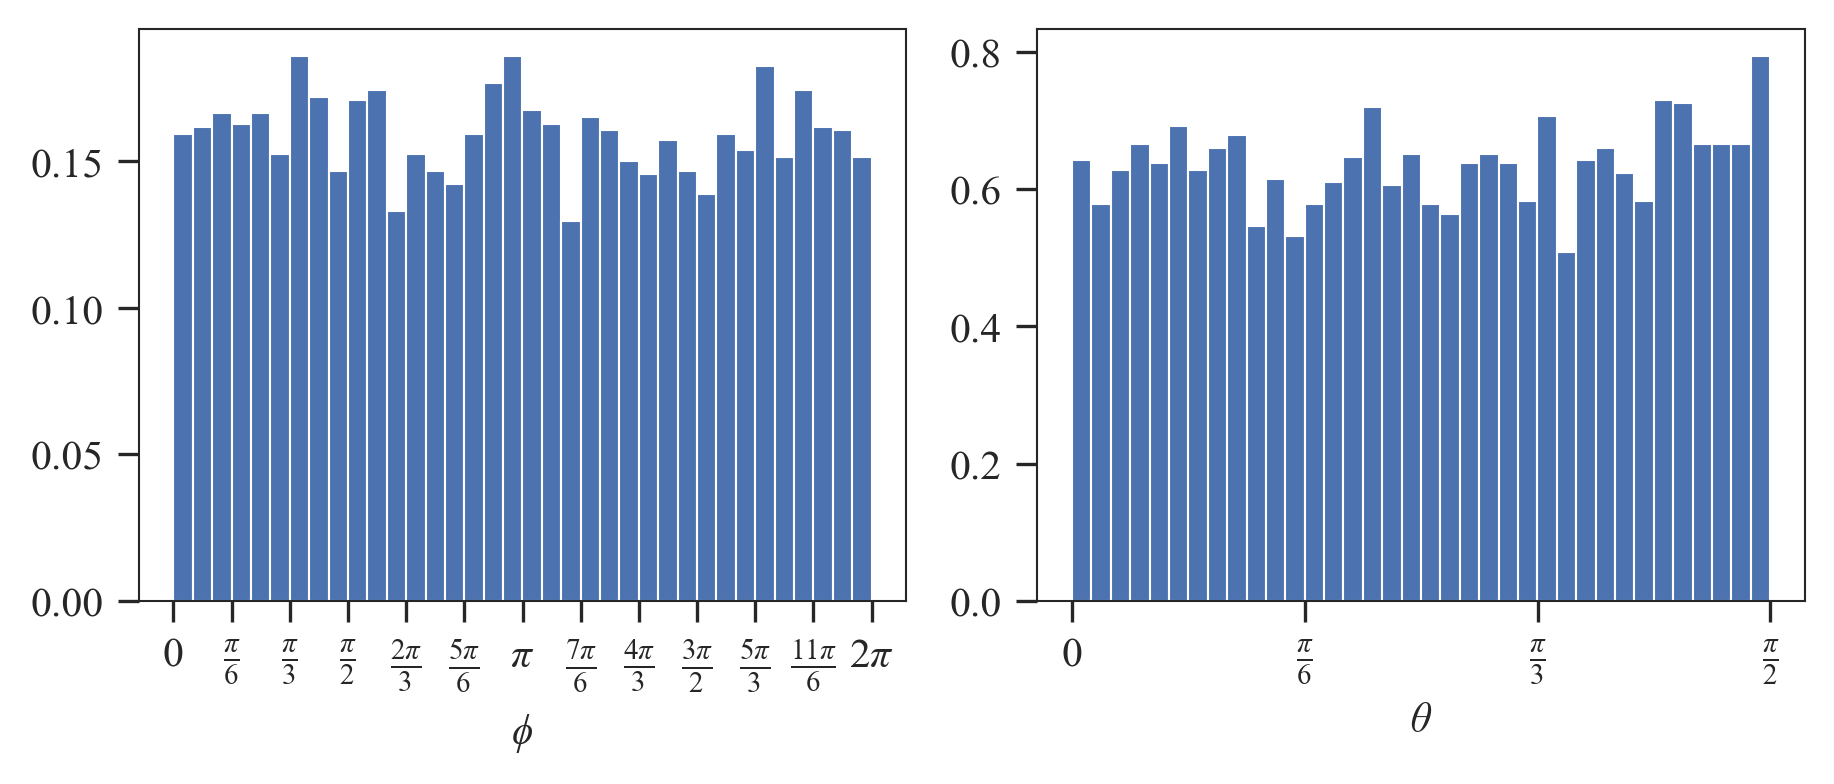

In [5]:
'''
A simple working code for 2nd order tensor in the lead up to testing for 4th order.
A spherical coordinate system with azimuthal angle phi and elevation theta are used to record orientations.
'''
# Probability function - the random input that varies for different test cases.
Nfib = 5000  # number of fibres

# # Domain-1: (0, pi), (0, pi)
# phiDomain = (0, np.pi)  # Domain of phi
# thtDomain = (0, np.pi)  # Domain of theta
# # phiObs = np.random.rand(Nfib) * np.pi
# # thtObs = np.random.rand(Nfib) * np.pi
# phiObs = np.random.uniform(size=Nfib) * np.pi
# iud = np.random.uniform(size=Nfib)
# thtObs = np.arccos(1 - 2*iud)

# Domain-2: (0, 2pi), (0, pi/2)
phiDomain = (0, 2*np.pi)  # Domain of phi
thtDomain = (0, np.pi/2)  # Domain of theta
phiObs = np.random.rand(Nfib) * 2 * np.pi
thtObs = np.random.rand(Nfib) * np.pi/2
# phiObs = np.random.uniform(size=Nfib) * 2*np.pi
# iud = np.random.uniform(size=Nfib)
# thtObs = np.arccos(1 - iud)

fig_tht_phi, axes = plt.subplots(1, 2, figsize=(6, 2.5), dpi=300)
axs = axes.ravel()
nbins = 36
h, phiBins, _ = axs[0].hist(phiObs, bins=nbins, density=True)
axs[0].set_xlabel("$\phi$")
axs[0].set_xticks(np.arange(0, np.max(phiBins)+np.pi/12, np.pi/6))
h, thtBins, _ = axs[1].hist(thtObs, bins=nbins, density=True)
axs[1].set_xlabel("$\\theta$")
axs[1].set_xticks(np.arange(0, np.max(thtBins)+np.pi/12, np.pi/6))
for ax in axs:
    ax.set_xticklabels(ANGLE_TICK_LABEL_DICT[len(ax.get_xticks())])

Total probability:  1.0


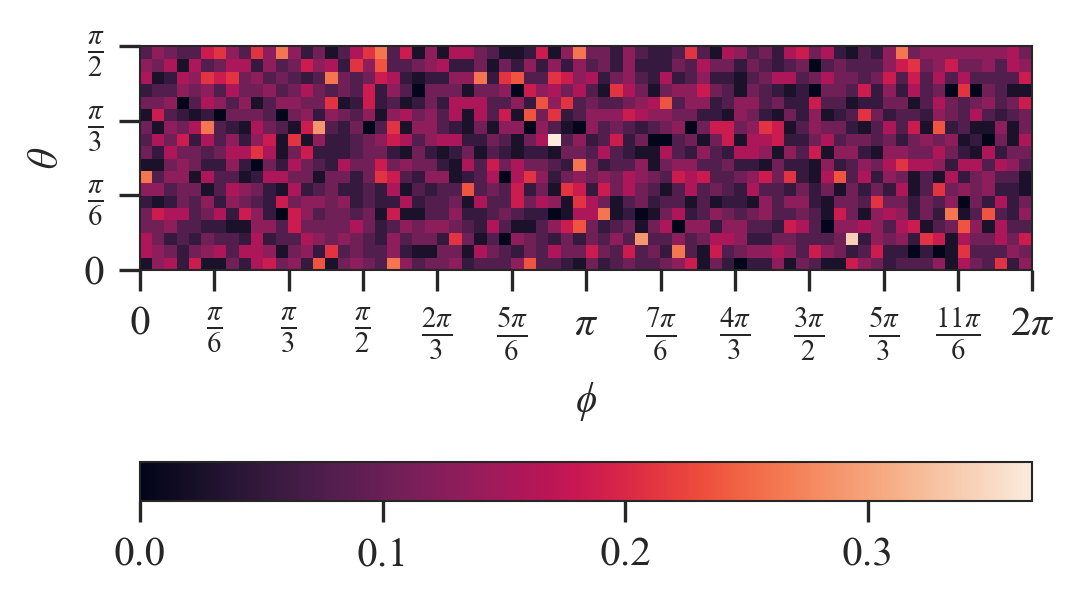

In [6]:
# Joint Probability
p_tht_phi, phiEdges, thtEdges, jointProbFig = joint_probability(thtObs, phiObs)
jointProbFig.savefig(os.path.join(outDir, "jointProbabilityHist.tiff"))

thtCentres = 0.5 * (thtEdges[1:] + thtEdges[:-1])
phiCentres = 0.5 * (phiEdges[1:] + phiEdges[:-1])

totalIntegral = np.trapz(np.trapz(p_tht_phi, thtCentres, axis=0), phiCentres, axis=-1)
assert np.isclose(totalIntegral, 1, atol=1e-1), print("Total integral not close to unity: {}".format(totalIntegral))
p_tht_phi = p_tht_phi / totalIntegral  # normalizing
print("Total probability: ", np.trapz(np.trapz(p_tht_phi, thtCentres, axis=0), phiCentres, axis=-1))

In [7]:
# Tensor
orientTensor2nd, anisoTensor2nd = tensor_2nd_order(p_tht_phi, thtCentres, phiCentres)
print("Orientation tensor: \n", orientTensor2nd)
print()
print("Anisotropy tensor: \n", anisoTensor2nd)

Orientation tensor: 
 [[ 2.53217328e-01  3.13326495e-04 -5.45517803e-03]
 [ 3.13326495e-04  2.53151451e-01  5.94830865e-04]
 [-5.45517803e-03  5.94830865e-04  4.93631220e-01]]

Anisotropy tensor: 
 [[-0.08011601  0.00031333 -0.00545518]
 [ 0.00031333 -0.08018188  0.00059483]
 [-0.00545518  0.00059483  0.16029789]]


In [8]:
# Rotation
anisoTensor2nd_rottd = rotate_2nd_order(anisoTensor2nd, rotAnglesDeg=(0, 0, 60))
print("Rotated Anisotropy Tensor: \n", anisoTensor2nd_rottd)
print("Checking the trace of rotated anisotropy tensor: ", np.trace(anisoTensor2nd_rottd))

Rotated Anisotropy Tensor: 
 [[-8.04367615e-02 -1.28137626e-04 -3.24272766e-03]
 [-1.28137626e-04 -7.98611256e-02 -4.42690732e-03]
 [-3.24272766e-03 -4.42690732e-03  1.60297887e-01]]
Checking the trace of rotated anisotropy tensor:  1.6653345369377348e-16


$$\newcommand{\vecb}[1]{\vec{\pmb{#1}}}
\newcommand{\uvecb}[1]{\hat{\pmb{#1}}}
$$
\begin{equation}
    \uvecb{u}' = R \uvecb{u}
\end{equation}

Let the rotated coordinate system be represented by the spherical coordinates $\psi$ and $\upsilon$. The direction cosines in this system can be written as:
\begin{equation}
    \begin{Bmatrix}
        u_1'\\
        u_2'\\
        u_3'
    \end{Bmatrix} =
    \begin{Bmatrix}
        \sin{\psi}\cos{\upsilon}\\
        \sin{\psi}\sin{\upsilon}\\
        \cos{\psi}
    \end{Bmatrix}
\end{equation}

The probability ditribution can be written with respect to the rotated system as:
\begin{align}
    p(\psi, \upsilon)   &= p(\uvecb{u}'=R\uvecb{u}) = p(\uvecb{u} = R^T\uvecb{u}')\\
                        &= p(u_j = R_{ji}u_i')\\
                        &= p\left(\theta=\arccos{(u_3)}, \phi=\arctan{\left(\frac{u_2}{u_1}\right)}\right)
\end{align}

In [ ]:
# Rotate Probability
phiVa

Total integral:  1.0006824549455025


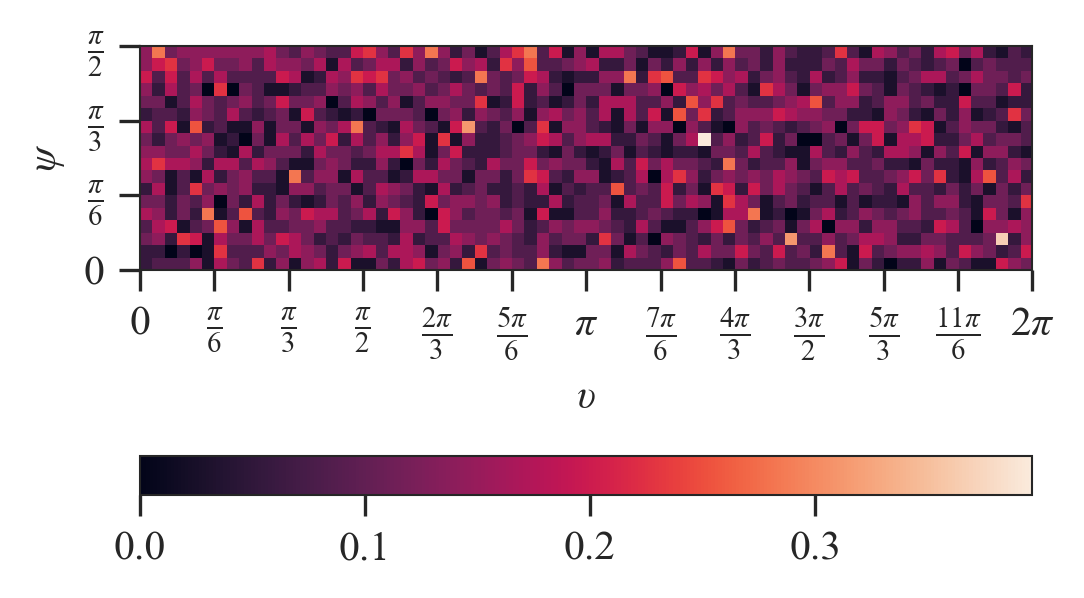

In [9]:
# Domain-2: (0, 2pi), (0, pi/2)
upsDomain = (0, 2*np.pi)  # Domain of phi
psiDomain = (0, np.pi/2)  # Domain of theta
step = np.deg2rad(5)
upsEdges  = np.arange(0, upsDomain[-1]+np.deg2rad(0.5), step)
psiEdges  = np.arange(0, psiDomain[-1]+np.deg2rad(0.5), step)
upsCentres = 0.5 * (upsEdges[1:] + upsEdges[:-1])
psiCentres = 0.5 * (psiEdges[1:] + psiEdges[:-1])

R = rotation_matrix(rotAnglesDeg=(0, 0, 60))

# unit vectors in rotated system:
uvec_rottd = np.zeros((3, len(psiCentres), len(upsCentres)))
uvec_rottd[0, :, :] = np.outer(np.sin(psiCentres), np.cos(upsCentres))
uvec_rottd[1, :, :] = np.outer(np.sin(psiCentres), np.sin(upsCentres))
uvec_rottd[2, :, :] = np.outer(np.cos(psiCentres), np.ones(len(upsCentres)))

uvec = np.tensordot(R.T, uvec_rottd, axes=([1, 0]))
thtCentresTransformed = np.arccos(uvec[2])
phiCentresTransformed = np.arctan2(uvec[1], uvec[0])
phiCentresTransformed = np.where(phiCentresTransformed > 0, 
                                 phiCentresTransformed, 
                                 2*np.pi + phiCentresTransformed
                                )
thtIndices = np.digitize(thtCentresTransformed, thtEdges) - 1
phiIndices = np.digitize(phiCentresTransformed, phiEdges) - 1
# print(thtIndices.min(), thtIndices.max())
# print(phiIndices.min(), phiIndices.max())
p_psi_ups = p_tht_phi[thtIndices, phiIndices]
p_psi_ups = p_psi_ups.reshape((len(psiCentres), len(upsCentres)))
totalIntegral = np.trapz(np.trapz(p_psi_ups, psiCentres, axis=0), upsCentres, axis=-1)
print("Total integral: ", totalIntegral)

jointprobFigTransformed = plt.figure(figsize=(3.5, 3), dpi=300)
ax = jointprobFigTransformed.gca()
ax.set_aspect('equal')
ax.set_ylabel("$\psi$")
ax.set_xlabel("$\\upsilon$")
xscale = len(upsCentres) / phiEdges[-1]
yscale = len(psiCentres) / thtEdges[-1]
xticks = np.arange(0, np.floor(xscale*(np.max(phiEdges)+np.pi/12)), np.floor(xscale*np.pi/6))
yticks = np.arange(0, np.floor(yscale*(np.max(thtEdges)+np.pi/12)), np.floor(yscale*np.pi/6))

imgTransformed = ax.imshow(p_psi_ups, origin='lower', 
                           extent=[xticks.min(), xticks.max(), yticks.min(), yticks.max()])
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_yticklabels(ANGLE_TICK_LABEL_DICT[len(yticks)])
ax.set_xticklabels(ANGLE_TICK_LABEL_DICT[len(xticks)])
plt.colorbar(imgTransformed, orientation='horizontal')

In [10]:
# Transformed Tensor
orientTensor2nd_transformed, anisoTensor2nd_transformed = tensor_2nd_order(p_psi_ups, 
                                                                           psiCentres, 
                                                                           upsCentres
                                                                          )
print("Orientation tensor: \n", orientTensor2nd_transformed)
print()
print("Anisotropy tensor: \n", anisoTensor2nd_transformed)
print()
print("Rotated Anisotropy tensor: \n", anisoTensor2nd_rottd)

Orientation tensor: 
 [[ 2.53507230e-01  3.14615211e-04 -5.40757621e-03]
 [ 3.14615211e-04  2.53358397e-01  5.86237628e-04]
 [-5.40757621e-03  5.86237628e-04  4.93708966e-01]]

Anisotropy tensor: 
 [[-0.0798261   0.00031462 -0.00540758]
 [ 0.00031462 -0.07997494  0.00058624]
 [-0.00540758  0.00058624  0.16037563]]

Rotated Anisotropy tensor: 
 [[-8.04367615e-02 -1.28137626e-04 -3.24272766e-03]
 [-1.28137626e-04 -7.98611256e-02 -4.42690732e-03]
 [-3.24272766e-03 -4.42690732e-03  1.60297887e-01]]


Following the approach in (Onat and Lockie 1984), the probability of fibres orientated in a direction $\uvecb{u}$ can be expanded in terms of spherical Fourier series as below:
\begin{equation}
    \tilde{p}(\uvecb{u}) = \dfrac{1}{4\pi} \left(1 + C_{ij} f_{ij} (\uvecb{u}) + C_{ijkl} f_{ijkl} (\uvecb{u}) + \varepsilon \right)
\end{equation}
where the Fourier basis functions are given by:
\begin{align}
    f_{ij} (\uvecb{u}) &= u_i u_j - \dfrac{1}{3} \delta_{ij}\\
    f_{ijkl} (\uvecb{u}) &= u_i u_j u_k u_l
    - \dfrac{1}{7} \left(\delta_{ij} u_k u_l + \delta_{ik} u_j u_l + \delta_{il} u_j u_k + \delta_{jk} u_i u_l + \delta_{jl} u_i u_k + \delta_{kl} u_i u_j \right)\nonumber\\
    &+ \frac{1}{5\times7} \left( \delta_{ij}\delta_{kl} + \delta_{ik}\delta_{jl} + \delta_{il}\delta_{jk}\right)
\end{align}

so that,
\begin{align}
    1 &= \int_{\Omega} \tilde{p}(\uvecb{u}) . 1 d\Omega\\
    C_{ij} &= \dfrac{3\times 5}{2} \int_{\Omega} \tilde{p}(\uvecb{u}) . f_{ij}(\uvecb{u}) d\Omega = \dfrac{15}{2} A_{ij}\\
    C_{ijkl} &= \dfrac{3\times 5 \times 7 \times 9}{2 \times 3 \times 4} \int_{\Omega} \tilde{p}(\uvecb{u}) . f_{ijkl}(\uvecb{u}) d\Omega = \dfrac{315}{8} A_{ijkl}
\end{align}
where $d\Omega = d\theta d\phi$.

When the anisotropy tensors are known, the series expansion of probability can be rewritten as:
\begin{equation}
    \tilde{p}(\uvecb{u}) = \dfrac{1}{4\pi} \left(1 + \dfrac{15}{2} A_{ij} f_{ij} (\uvecb{u}) + \dfrac{315}{8} A_{ijkl} f_{ijkl} (\uvecb{u}) + \varepsilon \right)
\end{equation}
 
 
Consider a rotated coordinate system in which the fibre directions cosines are $\uvecb{u}'$. The same series expansion can be rewritten in the new coordinate system as:
\begin{equation}
    \tilde{p}(\uvecb{u}') = \dfrac{1}{4\pi} \left(1 + C_{ij}' f_{ij} (\uvecb{u}') + C_{ijkl}' f_{ijkl} (\uvecb{u}') + \varepsilon' \right)
\end{equation}
where,
\begin{align}
    C_{ij}' &= \dfrac{3\times 5}{2} \int_{\Omega} \tilde{p}(\uvecb{u}) . f_{ij}(\uvecb{u}) d\Omega = \dfrac{15}{2} A_{ij}' = R_{mi}A_{ij}R_{jm}\\
    C_{ijkl}' &= \dfrac{315}{8} \int_{\Omega} \tilde{p}(\uvecb{u}) . f_{ijkl}(\uvecb{u}) d\Omega = \dfrac{315}{8} A_{ijkl}' = 
\end{align}